In [1]:
import pandas as pd
import urllib2
import matplotlib.pyplot as plt
import pyspark.sql.functions as fn
import pydoop.hdfs as hdfs
import seaborn as sns
from pyspark.sql.types import *
%matplotlib inline

In [6]:
def prepare_working_set(type_of_taxi):
    months = ['01', '02', '03', '04', '05']
    for month in months:
        fetch_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/" + type_of_taxi + "_tripdata_2018-" + month + ".csv"
        response = urllib2.urlopen(fetch_url)
        csv_file = type_of_taxi + "_tripdata_2018-" + month + ".csv"
        data = response.read()
        with open(csv_file, 'wb') as f:
            f.write(data)
        try: 
            hdfs.put(csv_file, "hdfs://analytix/user/dmielaik/" + csv_file)
        except:
            print("An exception occurred during writing to hdfs " + csv_file) 

In [2]:
prepare_working_set("yellow")

In [2]:
yellow_taxi = spark.read.csv('/user/dmielaik/yellow_tripdata_2018-*.csv', mode="FAILFAST", header=True, nullValue='null')

In [3]:
vendor_udf = fn.udf(lambda x: 'Creative Mobile Technologies' if '1' in x else 'VeriFone Inc.')    
yellow_data_agg = (yellow_taxi
                       .select("*")
                       .withColumn('pickup_week_day', fn.date_format('tpep_pickup_datetime', 'E'))
                       .withColumn('pickup_week_day_number', fn.date_format('tpep_pickup_datetime', 'u'))
                       .withColumn("trip_duration_in_s", fn.unix_timestamp('tpep_dropoff_datetime') - fn.unix_timestamp('tpep_pickup_datetime'))
                       .withColumn('pickup hour', fn.hour('tpep_pickup_datetime'))
                       .withColumn('vendor_type', vendor_udf(fn.col('VendorID')))
                   )

In [13]:
yellow_data_agg.limit(3).take(2)

[Row(VendorID=u'1', tpep_pickup_datetime=u'2018-01-01 00:21:05', tpep_dropoff_datetime=u'2018-01-01 00:24:23', passenger_count=u'1', trip_distance=u'.50', RatecodeID=u'1', store_and_fwd_flag=u'N', PULocationID=u'41', DOLocationID=u'24', payment_type=u'2', fare_amount=u'4.5', extra=u'0.5', mta_tax=u'0.5', tip_amount=u'0', tolls_amount=u'0', improvement_surcharge=u'0.3', total_amount=u'5.8', pickup_week_day=u'Mon', pickup_week_day_number=u'1', trip_duration in s=198, pickup hour=0, vendor_type=u'Creative Mobile Technologies'),
 Row(VendorID=u'1', tpep_pickup_datetime=u'2018-01-01 00:44:55', tpep_dropoff_datetime=u'2018-01-01 01:03:05', passenger_count=u'1', trip_distance=u'2.70', RatecodeID=u'1', store_and_fwd_flag=u'N', PULocationID=u'239', DOLocationID=u'140', payment_type=u'2', fare_amount=u'14', extra=u'0.5', mta_tax=u'0.5', tip_amount=u'0', tolls_amount=u'0', improvement_surcharge=u'0.3', total_amount=u'15.3', pickup_week_day=u'Mon', pickup_week_day_number=u'1', trip_duration in s=1

In [14]:
total_rides_by_pass = (yellow_data_agg
                           .groupby(['passenger_count'])
                           .agg(fn.count("passenger_count").alias("total_rides_count"))
                      )
total_rides_by_pass.show()

+---------------+-----------------+
|passenger_count|total_rides_count|
+---------------+-----------------+
|              7|              170|
|              3|          1836498|
|              8|              143|
|              0|           331395|
|              5|          2095875|
|              6|          1250216|
|              9|              115|
|              1|         32246241|
|              4|           855540|
|              2|          6595710|
|            192|                1|
+---------------+-----------------+



In [17]:
yellow_data_agg.groupby(['vendor_type']).agg(fn.count("vendor_type").alias("Vendor total count")).show(2, False)

+----------------------------+------------------+
|vendor_type                 |Vendor total count|
+----------------------------+------------------+
|Creative Mobile Technologies|19687063          |
|VeriFone Inc.               |25524841          |
+----------------------------+------------------+



In [98]:
pickup_week_day = (yellow_data_agg
                       .groupby(['pickup_week_day', 'vendor_type', 'pickup_week_day_number'])
                       .agg(fn.count("pickup_week_day").alias("pickup_week_day_count"))
                       .orderBy(fn.col('pickup_week_day_number'))
                  )

In [99]:
pickup_week_day.show(pickup_week_day.count(), False)

+---------------+----------------------------+----------------------+---------------------+
|pickup_week_day|vendor_type                 |pickup_week_day_number|pickup_week_day_count|
+---------------+----------------------------+----------------------+---------------------+
|Mon            |VeriFone Inc.               |1                     |3364850              |
|Mon            |Creative Mobile Technologies|1                     |2589922              |
|Tue            |VeriFone Inc.               |2                     |3699992              |
|Tue            |Creative Mobile Technologies|2                     |2876256              |
|Wed            |Creative Mobile Technologies|3                     |2899405              |
|Wed            |VeriFone Inc.               |3                     |3753356              |
|Thu            |VeriFone Inc.               |4                     |3929630              |
|Thu            |Creative Mobile Technologies|4                     |3057036    

In [100]:
pickup_week_day_df = pickup_week_day.toPandas()

[Text(0,0,u'Mon'),
 Text(0,0,u'Tue'),
 Text(0,0,u'Wed'),
 Text(0,0,u'Thu'),
 Text(0,0,u'Fri'),
 Text(0,0,u'Sat'),
 Text(0,0,u'Sun')]

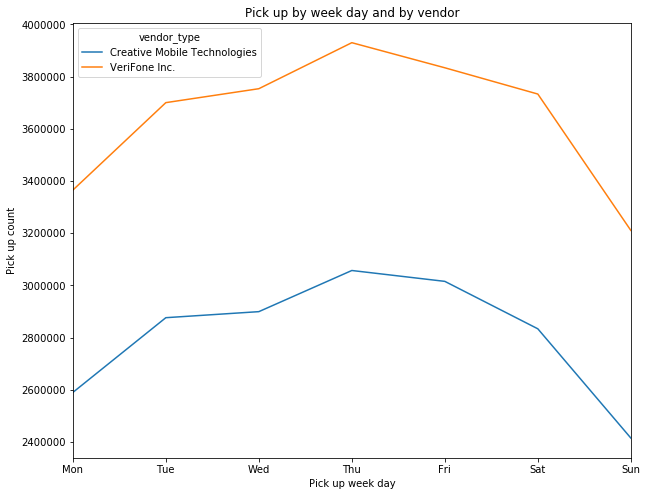

In [101]:
pickup_week_day_df.set_index(['pickup_week_day_number'], inplace=True)
pickup_week_day_pivot = pickup_week_day_df.pivot_table("pickup_week_day_count", pickup_week_day_df.index, "vendor_type")
ax = pickup_week_day_pivot.plot(figsize=(10, 8), title='Pick up by week day and by vendor')
ax.set_xlabel('Pick up week day')
ax.set_ylabel('Pick up count')
ax.set_xticklabels(pickup_week_day_df['pickup_week_day'].unique())

In [122]:
pickup_hour = (yellow_data_agg
                .groupby(['pickup hour'])
                .agg(fn.avg("trip_duration_in_s").alias("trip_avg"))
                .orderBy(fn.col('pickup hour'))
                .withColumn('trip_duration_avg', fn.round(fn.col('trip_avg'),2))
                .drop('trip_avg')
                )
pickup_hour.show(pickup_hour.count(), False)

+-----------+----------------------------+-----------------+
|pickup hour|vendor_type                 |trip_duration_avg|
+-----------+----------------------------+-----------------+
|0          |VeriFone Inc.               |1066.27          |
|0          |Creative Mobile Technologies|740.18           |
|1          |VeriFone Inc.               |1069.56          |
|1          |Creative Mobile Technologies|701.51           |
|2          |Creative Mobile Technologies|662.36           |
|2          |VeriFone Inc.               |1068.65          |
|3          |VeriFone Inc.               |1096.02          |
|3          |Creative Mobile Technologies|666.91           |
|4          |VeriFone Inc.               |1182.86          |
|4          |Creative Mobile Technologies|695.68           |
|5          |Creative Mobile Technologies|660.34           |
|5          |VeriFone Inc.               |1174.95          |
|6          |VeriFone Inc.               |1136.97          |
|6          |Creative Mo

In [120]:
yellow_data_agg.select('trip_distance', 'trip_duration_in_s', 'tpep_dropoff_datetime', 'tpep_pickup_datetime').where(yellow_data_agg.trip_duration_in_s.contains('-')).where(yellow_data_agg['VendorID'] == 1).show(yellow_data_agg.count(), False)

+-------------+------------------+---------------------+--------------------+
|trip_distance|trip_duration_in_s|tpep_dropoff_datetime|tpep_pickup_datetime|
+-------------+------------------+---------------------+--------------------+
|3.30         |-342695           |2017-12-28 16:03:38  |2018-01-01 15:15:13 |
|20.90        |-45834            |2018-01-23 00:28:25  |2018-01-23 13:12:19 |
|20.20        |-83321            |2018-02-03 16:06:36  |2018-02-04 15:15:17 |
|1.30         |-18111            |2018-02-09 04:48:28  |2018-02-09 09:50:19 |
|1.90         |-2574             |2018-02-09 15:14:23  |2018-02-09 15:57:17 |
|4.70         |-4226708          |2017-12-24 17:09:53  |2018-02-11 15:15:01 |
|.10          |-36               |2018-02-17 23:31:41  |2018-02-17 23:32:17 |
|9.90         |-83404            |2018-03-05 16:05:01  |2018-03-06 15:15:05 |
|1.50         |-2412             |2018-03-21 07:40:23  |2018-03-21 08:20:35 |
|1.20         |-349888           |2018-03-20 14:03:49  |2018-03-

In [123]:
pickup_hour_df = pickup_hour.toPandas()

In [124]:
pickup_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
pickup hour          48 non-null int32
vendor_type          48 non-null object
trip_duration_avg    48 non-null float64
dtypes: float64(1), int32(1), object(1)
memory usage: 1.0+ KB


In [125]:
pickup_hour_df.head()

,pickup hour,vendor_type,trip_duration_avg
0,0,Creative Mobile Technologies,740.18
1,0,VeriFone Inc.,1066.27
2,1,VeriFone Inc.,1069.56
3,1,Creative Mobile Technologies,701.51
4,2,VeriFone Inc.,1068.65


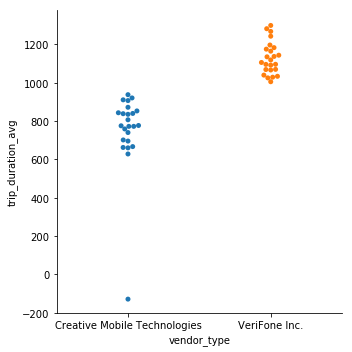

In [140]:
sns.catplot(x="vendor_type", y="trip_duration_avg", kind="swarm", data=pickup_hour_df)

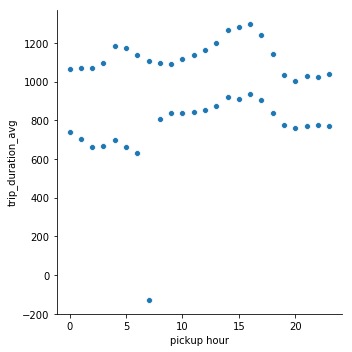

In [129]:
sns.relplot(x='pickup hour', y='trip_duration_avg', data=pickup_hour_df)

In [22]:
tip_amount_by_hour = (yellow_data_agg
            .groupby(['pickup hour'])
            .agg(fn.avg("tip_amount").alias("tip_amount_avg"), fn.avg("total_amount").alias("total_amount_avg"))
            .withColumn('tip_avg', fn.round(fn.col('tip_amount_avg'),2))
            .withColumn('trip_avg', fn.round(fn.col('total_amount_avg'),2))
            .drop('tip_amount_avg')
            .drop('total_amount_avg')
            .orderBy(fn.col('pickup hour'))
       )
tip_amount_by_hour.show(10, False)

+-----------+-------+--------+
|pickup hour|tip_avg|trip_avg|
+-----------+-------+--------+
|0          |1.92   |16.6    |
|1          |1.77   |15.78   |
|2          |1.65   |15.22   |
|3          |1.61   |15.77   |
|4          |1.79   |18.35   |
|5          |2.14   |19.64   |
|6          |1.77   |15.62   |
|7          |1.77   |14.8    |
|8          |1.81   |14.95   |
|9          |1.8    |15.14   |
+-----------+-------+--------+
only showing top 10 rows



In [23]:
tip_amount_by_hour_df = tip_amount_by_hour.toPandas()

In [24]:
tip_amount_by_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
pickup hour    24 non-null int32
tip_avg        24 non-null float64
trip_avg       24 non-null float64
dtypes: float64(2), int32(1)
memory usage: 552.0 bytes


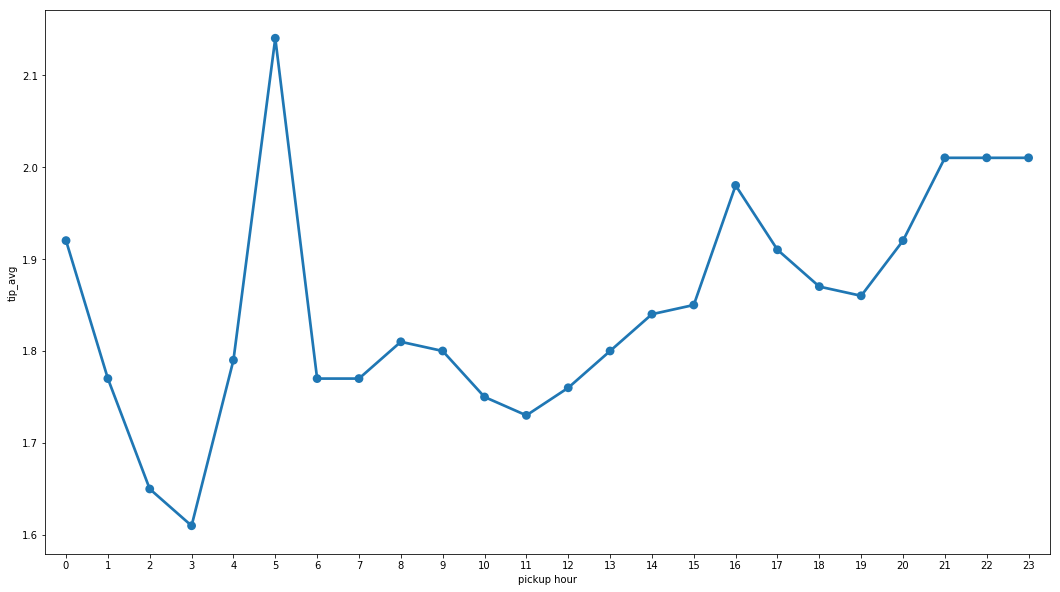

In [26]:
plt.figure(figsize=(18,10))
sns.pointplot(tip_amount_by_hour_df['pickup hour'], tip_amount_by_hour_df['tip_avg'])